## Read the data and preprocess it. 

- Read the spacial and temportal feature dataset.
- Filter and select the dataset within our space of consideration.
- shift coordinates for plotting.

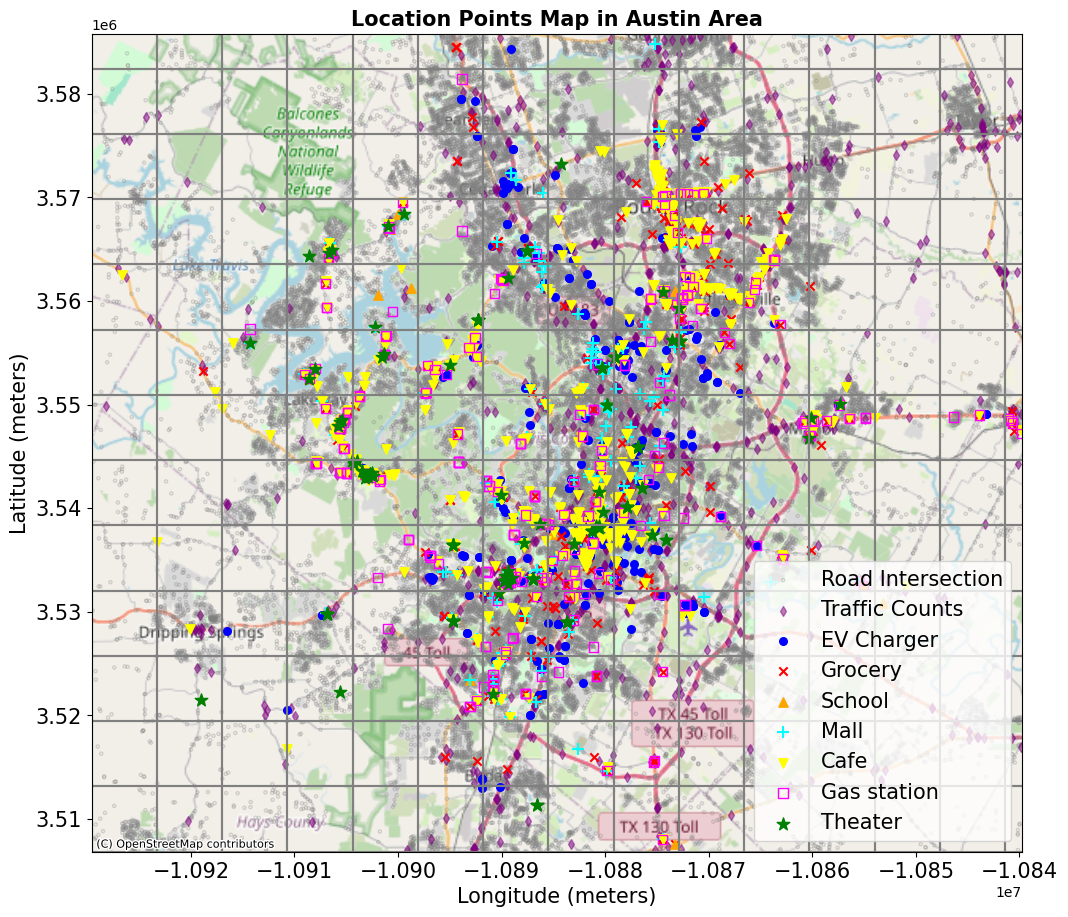

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon
import contextily as ctx
import pandas as pd
import numpy as np
import seaborn as sns
from math import sqrt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_predict
import seaborn as sns
from imblearn.over_sampling import SMOTE
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score 
from pyproj import Transformer
from haversine import haversine
from gurobipy import Model, GRB, quicksum, max_, min_, abs_
from scipy.spatial.distance import cdist
import os
os.makedirs('Figures',exist_ok = True)
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.options.mode.chained_assignment = None 
pd.set_option('display.max_rows', None)

df_EV = pd.read_excel("AustinAreabyCity/filtered_file_EV charger station.xlsx")
df_grocery = pd.read_excel("AustinAreabyCity/filtered_file_Grocery store.xlsx")
df_school = pd.read_excel("AustinAreabyCity/filtered_file_school.xlsx")
df_mall = pd.read_excel("AustinAreabyCity/filtered_file_shopping mall.xlsx")
df_cafe = pd.read_excel("AustinAreabyCity/filtered_file_cafe.xlsx")
df_gas = pd.read_excel("AustinAreabyCity/filtered_file_gas station.xlsx")
df_theater = pd.read_excel("AustinAreabyCity/filtered_file_theater.xlsx")
df_intersection = pd.read_csv("Transportation network/Austin_transport_intersections.csv",usecols=['lon','lat','street_count'])
df_intersection.columns = ['Longitude','Latitude','street_count']
df_intersection = df_intersection[['Latitude','Longitude','street_count']]
df_traffic = pd.read_csv("Traffic/TxDOT AADT Annuals.csv", usecols=['y','x','AADT_2022'])
df_traffic.columns = ['TrafficCount','Longitude','Latitude']
df_traffic = df_traffic[['Latitude','Longitude','TrafficCount']]
def filter_df(df, lat_lower, lat_upper, long_lower, long_upper):
    # Filter the DataFrame rows based on latitude and longitude bounds
    filtered_df = df[
        (df['Latitude'] >= lat_lower) & (df['Latitude'] <= lat_upper) &
        (df['Longitude'] >= long_lower) & (df['Longitude'] <= long_upper)
    ]
    
    # Return the filtered DataFrame
    return filtered_df

min_long_1 = -98.18209496908116
max_long_1 = -97.37545599658112
min_lat_1 = 30.0254665608216
max_lat_1 = 30.637603376614

# min_long_1 = -98.18209496908116
# max_long_1 = -97.8
# min_lat_1 = 30.3
# max_lat_1 = 30.637603376614

lat_lower_bound = min_lat_1 
lat_upper_bound = max_lat_1 
long_lower_bound = min_long_1 
long_upper_bound = max_long_1 

df_EV = filter_df(df_EV, min_lat_1, max_lat_1, min_long_1, max_long_1)
df_traffic = filter_df(df_traffic, min_lat_1, max_lat_1, min_long_1, max_long_1)
df_traffic = df_traffic.reset_index(drop=True)


# points_set_1 = list(zip(df_EV['Latitude'], df_EV['Longitude']))  
filtered_points_set_1 = list(zip(df_EV['Latitude'], df_EV['Longitude']))  
points_set_2 = list(zip(df_grocery['Latitude'], df_grocery['Longitude'])) 
points_set_3 = list(zip(df_school['Latitude'], df_school['Longitude']))
points_set_4 = list(zip(df_mall['Latitude'], df_mall['Longitude']))    
points_set_5 = list(zip(df_cafe['Latitude'], df_cafe['Longitude']))
points_set_6 = list(zip(df_gas['Latitude'], df_gas['Longitude']))   
points_set_7 = list(zip(df_theater['Latitude'], df_theater['Longitude']))    
points_set_8 = list(zip(df_intersection['Latitude'],df_intersection['Longitude']))
points_set_9 = list(zip(df_traffic['Latitude'],df_traffic['Longitude']))


def filter_points(points, lat_lower, lat_upper, long_lower, long_upper):
    return [(lat, lon) for lat, lon in points if lat_lower <= lat <= lat_upper and long_lower <= lon <= long_upper]

# filtered_points_set_1 = filter_points(points_set_1, lat_lower_bound, lat_upper_bound, long_lower_bound, long_upper_bound)
filtered_points_set_2 = filter_points(points_set_2, lat_lower_bound, lat_upper_bound, long_lower_bound, long_upper_bound)
filtered_points_set_3 = filter_points(points_set_3, lat_lower_bound, lat_upper_bound, long_lower_bound, long_upper_bound)
filtered_points_set_4 = filter_points(points_set_4, lat_lower_bound, lat_upper_bound, long_lower_bound, long_upper_bound)
filtered_points_set_5 = filter_points(points_set_5, lat_lower_bound, lat_upper_bound, long_lower_bound, long_upper_bound)
filtered_points_set_6 = filter_points(points_set_6, lat_lower_bound, lat_upper_bound, long_lower_bound, long_upper_bound)
filtered_points_set_7 = filter_points(points_set_7, lat_lower_bound, lat_upper_bound, long_lower_bound, long_upper_bound)
filtered_points_set_8 = filter_points(points_set_8, lat_lower_bound, lat_upper_bound, long_lower_bound, long_upper_bound)
filtered_points_set_9 = filter_points(points_set_9, lat_lower_bound, lat_upper_bound, long_lower_bound, long_upper_bound)
# Approximate lat/lon extent for Austin (latitude and longitude)
north, south, east, west = lat_upper_bound, lat_lower_bound, long_upper_bound, long_lower_bound

# Convert these lat/lon values to EPSG:3857 (meters) using GeoPandas
# Create a GeoDataFrame with the bounding box corners
df_extent = gpd.GeoDataFrame(geometry=[Point(west, south), Point(east, north)], crs="EPSG:4326")

# Reproject to Web Mercator (EPSG:3857)
df_extent = df_extent.to_crs(epsg = 3857)

# Get the bounds in meters for the Austin area
minx, miny = df_extent.total_bounds[0], df_extent.total_bounds[1]
maxx, maxy = df_extent.total_bounds[2], df_extent.total_bounds[3]

# Function to generate grid cells, and give name of grid_cells_ID
def create_grid(minx, miny, maxx, maxy, grid_size):
    x_vals = np.arange(minx, maxx, grid_size)
    y_vals = np.arange(miny, maxy, grid_size)
    
    grid_cells = []
    grid_cells_ID = []
    xi=0
    for x in x_vals:
        xi=xi+1
        yi=0
        for y in y_vals:
            yi=yi+1
            grid_cells.append(Polygon([(x, y), (x + grid_size, y), (x + grid_size, y + grid_size), (x, y + grid_size)]))
            grid_cells_ID.append((xi,yi))
    
    return grid_cells_ID, grid_cells, x_vals, y_vals


def calculate_distance_and_radius(x_min, x_max, y_min, y_max, point):
    # center of the grid cell
    center_x = (x_min + x_max) / 2
    center_y = (y_min + y_max) / 2

    # Calculate the radius as the width of the grid cell
    radius = x_max - x_min

    # Calculate the Euclidean distance from the point to the center of the circle
    distance = sqrt((point.x - center_x) ** 2 + (point.y - center_y) ** 2)

    return distance, radius

# Generate a grid
grid_size = 6300  # 400 meters ##################################################################

# def data_prepare(grid_size):
    
grid_cells_ID, grid_cells, x_vals, y_vals = create_grid(minx, miny, maxx, maxy, grid_size)

# Create a GeoDataFrame for the grid
gdf_grid = gpd.GeoDataFrame(geometry=grid_cells, crs="EPSG:3857")
# gdf_grid = gpd.GeoDataFrame(geometry=grid_cells, crs="EPSG:4326")

# Create a GeoDataFrame for both sets of points in WGS84 (lat/lon)
gdf_set_1 = gpd.GeoDataFrame(geometry=[Point(lon, lat) for lat, lon in filtered_points_set_1], crs="EPSG:4326")
# gdf_set_1_radius = df_EV['Mean Coverage (miles)']
gdf_set_2 = gpd.GeoDataFrame(geometry=[Point(lon, lat) for lat, lon in filtered_points_set_2], crs="EPSG:4326")
gdf_set_3 = gpd.GeoDataFrame(geometry=[Point(lon, lat) for lat, lon in filtered_points_set_3], crs="EPSG:4326")
gdf_set_4 = gpd.GeoDataFrame(geometry=[Point(lon, lat) for lat, lon in filtered_points_set_4], crs="EPSG:4326")
gdf_set_5 = gpd.GeoDataFrame(geometry=[Point(lon, lat) for lat, lon in filtered_points_set_5], crs="EPSG:4326")
gdf_set_6 = gpd.GeoDataFrame(geometry=[Point(lon, lat) for lat, lon in filtered_points_set_6], crs="EPSG:4326")
gdf_set_7 = gpd.GeoDataFrame(geometry=[Point(lon, lat) for lat, lon in filtered_points_set_7], crs="EPSG:4326")
gdf_set_8 = gpd.GeoDataFrame(geometry=[Point(lon, lat) for lat, lon in filtered_points_set_8], crs="EPSG:4326")
gdf_set_9 = gpd.GeoDataFrame(geometry=[Point(lon, lat) for lat, lon in filtered_points_set_9], crs="EPSG:4326")
# Reproject the GeoDataFrames to Web Mercator (EPSG:3857)
gdf_set_1 = gdf_set_1.to_crs(epsg=3857)
# gdf_set_1['geometry'] = gdf_set_1.geometry.buffer(1600*gdf_set_1_radius)
gdf_set_2 = gdf_set_2.to_crs(epsg=3857)
gdf_set_3 = gdf_set_3.to_crs(epsg=3857)
gdf_set_4 = gdf_set_4.to_crs(epsg=3857)
gdf_set_5 = gdf_set_5.to_crs(epsg=3857)
gdf_set_6 = gdf_set_6.to_crs(epsg=3857)
gdf_set_7 = gdf_set_7.to_crs(epsg=3857)
gdf_set_8 = gdf_set_8.to_crs(epsg=3857)
gdf_set_9 = gdf_set_9.to_crs(epsg=3857)
# Create a plot
fig, ax = plt.subplots(figsize=(12, 12))

# Plot the grid
gdf_grid.boundary.plot(ax=ax, color="gray", linewidth=1.5, alpha=0.99)

# Plot both sets of points in the new coordinate system (meters)
gdf_set_8.plot(ax=ax, color='grey', facecolor='none', label='Road Intersection', marker='o', alpha=0.3, markersize=5)
gdf_set_9.plot(ax=ax, color='purple', label='Traffic Counts',  marker='d', alpha=0.5, markersize=25)
gdf_set_1.plot(ax=ax, color = 'blue', label='EV Charger', marker='o', markersize=30)
# gdf_set_1.plot(ax=ax, edgecolor='blue', facecolor='none', marker='o', markersize=30, alpha=0.72)
gdf_set_2.plot(ax=ax, color='red', label='Grocery', marker='x', markersize=36)
gdf_set_3.plot(ax=ax, color='orange', label='School', marker='^', markersize=45) ############
gdf_set_4.plot(ax=ax, color='cyan', label='Mall', marker='+', markersize=72)
gdf_set_5.plot(ax=ax, color='yellow', label='Cafe', marker='v', markersize=45)
gdf_set_6.plot(ax=ax, color='magenta', facecolor='none', label='Gas station', marker='s', markersize=45)
gdf_set_7.plot(ax=ax, color='green', label='Theater',  marker='*', markersize=90)

# Set the bounding box for the Austin area (in meters)
ax.set_xlim([minx, maxx])
ax.set_ylim([miny, maxy])

# Add a basemap (tile) to give the background using OpenStreetMap (EPSG:3857)
ctx.add_basemap(ax, crs=gdf_set_1.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)

ax.set_title("Location Points Map in Austin Area", fontsize=15, fontweight='bold')
plt.xlabel("Longitude (meters)",fontsize=15)
plt.ylabel("Latitude (meters)",fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize = 15)
plt.legend(fontsize = 15,loc='lower right')
plt.savefig('Figures\LocationPointsMap.pdf',bbox_inches='tight')
plt.show()

# df_EV_filtered = df_EV[['Latitude', 'Longitude', 'Charger Number', 'Max Power (kW)', 'Max Capacity (kWh)']]
df_EV_filtered = df_EV[['Latitude', 'Longitude', 'ChargerNumber', 'trainingHr', 'trainingEVdemand']]
df_EV_filtered['Longitude_EPSG3857'] = gdf_set_1.geometry.x
df_EV_filtered['Latitude_EPSG3857'] = gdf_set_1.geometry.y
df_EV_filtered = df_EV_filtered.dropna() #######################################

In [2]:
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import Polygon
import ast  # For safely parsing string representations of Python objects

def fix_trainingHr_format(value):
    if isinstance(value, str) and '[' in value and ']' in value:
        # Replace spaces with commas, but preserve the brackets
        value = value.replace('[', '').replace(']', '').replace(' ', ', ').replace(';', ', ')
        return f"[{value}]"
    return value
# Function to create a grid
# def create_grid(minx, miny, maxx, maxy, grid_size):
#     x_vals = np.arange(minx, maxx, grid_size)
#     y_vals = np.arange(miny, maxy, grid_size)
#     grid_cells = [
#         Polygon([(x, y), (x + grid_size, y), (x + grid_size, y + grid_size), (x, y + grid_size)])
#         for x in x_vals
#         for y in y_vals
#     ]
#     return grid_cells, x_vals, y_vals


# Function to calculate hourly EV demand
# Function to calculate hourly EV demand
def calculate_hourly_demand(points, grid_bounds, hours_range):
    """
    Calculate the sum of EV demand for each hour within the specified grid bounds.

    Args:
    - points (pd.DataFrame): Filtered EV dataset.
    - grid_bounds (tuple): (x_min, x_max, y_min, y_max) defining the grid cell boundaries.
    - hours_range (range): Range of hours (e.g., range(24) for 24-hour data).

    Returns:
    - dict: Hourly demand aggregated within the grid bounds.
    """
    x_min, x_max, y_min, y_max = grid_bounds
    hour_demand_sum = {h: 0 for h in hours_range}  # Initialize hourly demand

    for _, row in points.iterrows():
        # Check if the point is within the grid cell bounds
        if x_min <= row['Longitude_EPSG3857'] < x_max and y_min <= row['Latitude_EPSG3857'] < y_max:
            # Reshape and extract hourly demand data
            single_row_df = row.to_frame().T
            pc1 = reshape_temporal_data(single_row_df)  # Use your working logic
            hour_demand = list(zip(pc1['trainingHr'], pc1['trainingEVdemand']))

            # Aggregate demand for each hour
            for hour, demand in hour_demand:
                hour = int(hour)
                hour_demand_sum[hour] += demand

    return hour_demand_sum

def reshape_temporal_data(df):
    rows = []
    for i,row in df.iterrows():
        Latitude = row['Latitude']
        Longitude = row['Longitude']
        # Longitude_EPSG3857 = row['Longitude_EPSG3857']
        # Latitude_EPSG3857 = row['Latitude_EPSG3857']
        # center = row['center']
        hours = row['trainingHr'].strip('[]').split(' ')
        if 'trainingFrequency' in row:
            frequencies = list(map(float,row['trainingFrequency'].strip('[]').split(';')))
            for hour, frequency in zip(hours, frequencies):
                rows.append({'Latitude':Latitude,
                            'Longitude': Longitude,
                            'trainingHr': hour,
                            'trainingFrequency':frequency,
                            # 'Longitude_EPSG3857': Longitude_EPSG3857,
                            # 'Latitude_EPSG3857': Latitude_EPSG3857,
                            # 'center': center
                            })
        elif 'trainingEVdemand' in row:
            demands = list(map(float,row['trainingEVdemand'].strip('[]').split(';')))
            for hour, demand in zip(hours, demands):
                rows.append({'Latitude':Latitude,
                            'Longitude': Longitude,
                            'trainingHr': hour,
                            'trainingEVdemand':demand,
                            # 'Longitude_EPSG3857': Longitude_EPSG3857,
                            # 'Latitude_EPSG3857': Latitude_EPSG3857,
                            # 'center': center
                            })
    return pd.DataFrame(rows)

# Function to process POI frequencies
import ast  # For safely parsing string representations of Python objects

def process_poi_frequencies(poi_gdf, poi_data, grid_bounds, poi_name, hours_range):
    x_min, x_max, y_min, y_max = grid_bounds
    frequency = {h: 0 for h in hours_range}
    frequency_count = {h: 0 for h in hours_range}
    total_poi_count = 0
    for i, row in poi_gdf.iterrows():
        point = row['geometry']
        if x_min <= point.x < x_max and y_min <= point.y < y_max:
            total_poi_count += 1  # Increment total POI count for each match
            poi_info = poi_data.iloc[i]
            poi_info['trainingHr'] = fix_trainingHr_format(poi_info['trainingHr'])
            poi_info['trainingFrequency'] = fix_trainingHr_format(poi_info['trainingFrequency'])

            # Safely parse lists from strings, if necessary
            if isinstance(poi_info['trainingHr'], str):
                poi_info['trainingHr'] = ast.literal_eval(poi_info['trainingHr'])
            if isinstance(poi_info['trainingFrequency'], str):
                poi_info['trainingFrequency'] = ast.literal_eval(poi_info['trainingFrequency'])

            # Ensure the data is iterable
            hours = map(int, poi_info['trainingHr'])
            freqs = poi_info['trainingFrequency']

            for h, freq in zip(hours, freqs):
                frequency[h] += freq
                frequency_count[h] += 1
    return frequency, total_poi_count

# Function to calculate intersection counts by category
def calculate_intersection_count_by_category(df_intersection, grid_bounds, IntersNumsStr):
    x_min, x_max, y_min, y_max = grid_bounds
    counts = {col: 0 for col in IntersNumsStr}
    for _, row in df_intersection.iterrows():
        if x_min <= row['Longitude_EPSG3857'] < x_max and y_min <= row['Latitude_EPSG3857'] < y_max:
            street_count = row['street_count']
            if f"IntersNum_{int(street_count)}" in counts:
                counts[f"IntersNum_{int(street_count)}"] += 1
    return counts
# Function to calculate total traffic count
def calculate_traffic_count(df_traffic, grid_bounds):
    x_min, x_max, y_min, y_max = grid_bounds
    total_traffic = 0
    for _, row in df_traffic.iterrows():
        if x_min <= row['Longitude_EPSG3857'] < x_max and y_min <= row['Latitude_EPSG3857'] < y_max:
            total_traffic += row['TrafficCount']
    return total_traffic

# Main data preparation function
def prepare_training_data_with_columns(grid_size, df_EV_filtered, gdf_pois,df_traffic, df_intersection, x_vals, y_vals):
    # Define training columns
    POIs = ['grocery', 'school', 'mall', 'cafe', 'gas', 'theater']
    POIsNum = [n + 'Num' for n in POIs]
    IntersectNums = sorted(df_intersection['street_count'].unique().tolist())
    IntersNumsStr = ['IntersNum_' + str(n) for n in IntersectNums]
    training_columns = ['GridCell','GridCellID', 'Hour', 'EVdemand'] + POIs + POIsNum + ['TrafficFlow'] + IntersNumsStr
    
    # Placeholder for training data rows
    training_rows = []

    # Loop through grid cells
    for xi, x in enumerate(x_vals, start=1):
        for yi, y in enumerate(y_vals, start=1):
            # Define grid cell boundaries
            grid_bounds = (x, x + grid_size, y, y + grid_size)
            grid_id = f"{xi}-{yi}"  # Define grid cell ID
            # Initialize data for this grid cell
            ev_hourly_demand = calculate_hourly_demand(df_EV_filtered,grid_bounds, range(24))
            poi_frequencies = {}
            poi_counts = {}
            for poi_name, (poi_gdf, poi_df) in gdf_pois.items():
                freq, count = process_poi_frequencies(poi_gdf, poi_df, grid_bounds, poi_name, range(24))
                poi_frequencies[poi_name] = freq
                poi_counts[poi_name] = count
            # Intersection and Traffic Counts
            traffic_count = calculate_traffic_count(df_traffic, grid_bounds)
            intersection_counts = calculate_intersection_count_by_category(df_intersection, grid_bounds, IntersNumsStr)
            # Add data for each hour
            for hour in range(24):
                row = {
                    'GridCell': grid_bounds,
                    'GridCellID': grid_id,
                    'Hour': hour,
                    'EVdemand': ev_hourly_demand[hour],
                    **{poi: poi_frequencies[poi].get(hour, 0) for poi in POIs},
                    **{poi + 'Num': poi_counts[poi] for poi in POIs},
                    'TrafficFlow': traffic_count,
                    **intersection_counts
                }
                training_rows.append(row)
    
    # Create DataFrame with the specified columns
    df_training = pd.DataFrame(training_rows, columns=training_columns)
    return df_training

# Ensure EPSG:3857 coordinates for gdf_ev
df_intersection["Longitude_EPSG3857"] = gdf_set_8.geometry.x
df_intersection["Latitude_EPSG3857"] = gdf_set_8.geometry.y
df_traffic["Longitude_EPSG3857"] = gdf_set_9.geometry.x
df_traffic["Latitude_EPSG3857"] = gdf_set_9.geometry.y
df_EV_filtered["Longitude_EPSG3857"] = gdf_set_1.geometry.x
df_EV_filtered["Latitude_EPSG3857"] = gdf_set_1.geometry.y


# Function definitions remain the same...
def prepare_geodataframe(gdf):
    gdf = gdf.to_crs(epsg=3857)
    gdf['Longitude_EPSG3857'] = gdf.geometry.x
    gdf['Latitude_EPSG3857'] = gdf.geometry.y
    return gdf



gdf_pois = {                                      # POIs
    'grocery': (prepare_geodataframe(gdf_set_2), df_grocery),
    'school': (prepare_geodataframe(gdf_set_3), df_school),
    'mall': (prepare_geodataframe(gdf_set_4), df_mall),
    'cafe': (prepare_geodataframe(gdf_set_5), df_cafe),
    'gas': (prepare_geodataframe(gdf_set_6), df_gas),
    'theater': (prepare_geodataframe(gdf_set_7), df_theater)
}
# Example usage:
# grid_size = 6300  # Grid size in meters

grid_cells_ID, grid_cells, x_vals, y_vals = create_grid(minx, miny, maxx, maxy, grid_size)

# Generate training DataFrame
df_training_original = prepare_training_data_with_columns(
    grid_size, df_EV_filtered, gdf_pois, df_traffic, df_intersection,x_vals, y_vals
)
# Set 'GridCell' as the index
df_training_original.set_index('GridCell', inplace=True)


def filter_zero_demand_grids(df_training):
    """
    Filter out grid cells where EV demand is zero for all 24 hours.
    Args:
    - df_training (pd.DataFrame): Original training DataFrame with EV demand.
    Returns:
    - pd.DataFrame: Filtered DataFrame with non-zero demand grid cells.
    """
    # Group by GridCell and check if the sum of EVdemand is zero for all hours
    non_zero_grids = df_training.groupby('GridCellID')['EVdemand'].sum()
    non_zero_grids = non_zero_grids[non_zero_grids > 0].index  # Keep only grids with non-zero demand

    # Filter the original DataFrame to include only these grid cells
    filtered_df = df_training[df_training['GridCellID'].isin(non_zero_grids)]

    return filtered_df
df_training_filtered = filter_zero_demand_grids(df_training_original)

def filter_zero_based_on_columns(df_training, cols_to_check):
    """
    Filter out grid cells where all specified columns have zero values for all 24 hours.

    Args:
    - df_training (pd.DataFrame): Original training DataFrame.
    - cols_to_check (list): List of column names to check for zero values.

    Returns:
    - pd.DataFrame: Filtered DataFrame with grid cells where the specified columns are not all zero.
    """
    # Group by GridCell and check if all specified columns sum to zero
       # Group by GridCell and calculate the sum of specified columns
    grid_sums = df_training.groupby('GridCellID')[cols_to_check].sum()
    
    # Find grids where all specified columns are zero
    all_zero_grids = grid_sums[(grid_sums == 0).all(axis=1)].index

    # Find grids where at least one column is non-zero
    non_zero_grids = grid_sums[~(grid_sums == 0).all(axis=1)].index

    # Filter the original DataFrame
    filtered_df = df_training[df_training['GridCellID'].isin(non_zero_grids)]
    filtered_out_df = df_training[df_training['GridCellID'].isin(all_zero_grids)]

    return filtered_df, filtered_out_df

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


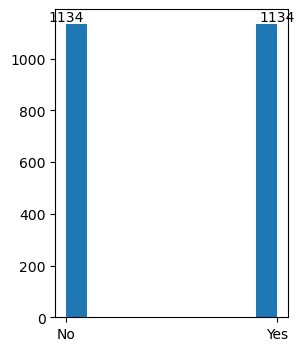

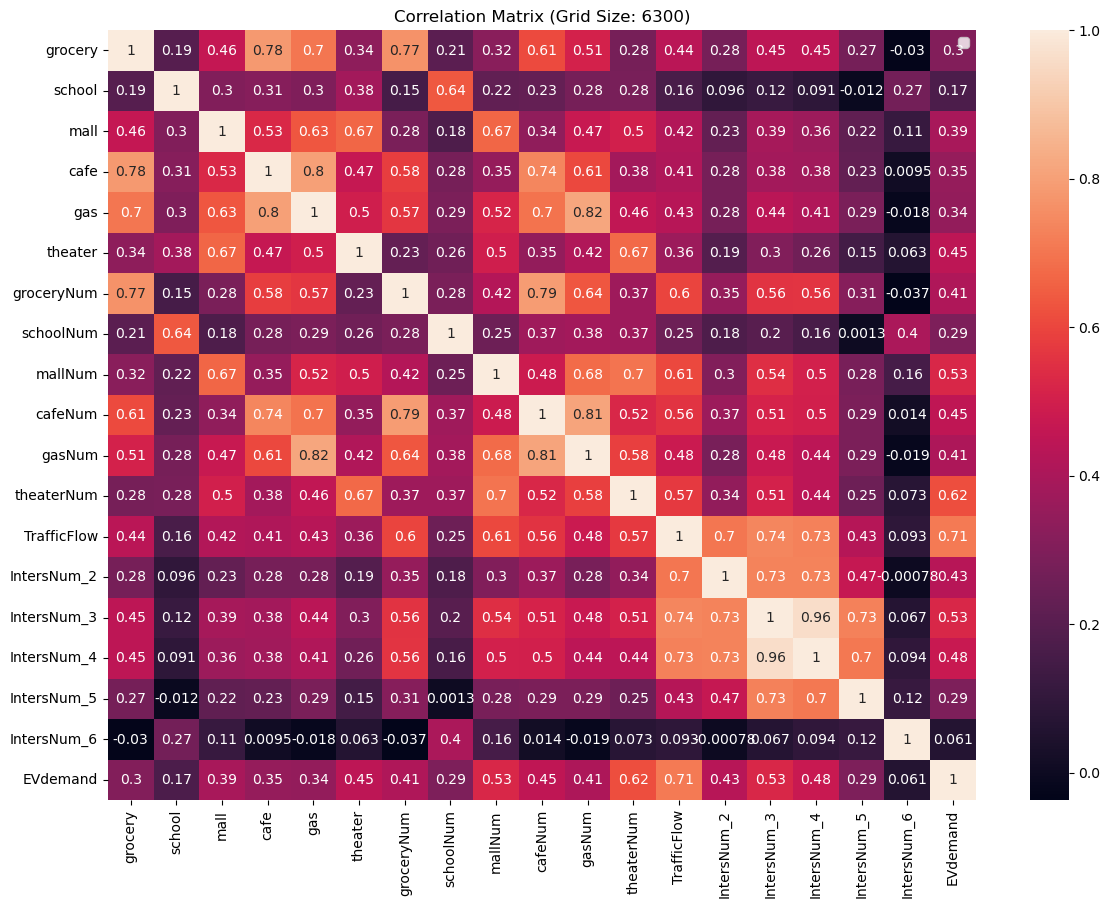

Length of training dataset:  2136
Length of testing dataset:  2544
Length of ALL zero dataset:  1080



In [3]:
# C1:0 EV, 0 POI (training)
# C2:With EV, With POI (training)
# C3:0 EV, with POI (prediction)
# C4:With EV, 0 POI (NA data, eleminate)

#original dataframe
df_origin_copy = df_training_original.copy()
#split with EVdemand and without EVdemand
df_ev_nonZero, df_ev_Zero = filter_zero_based_on_columns(df_training_original,['EVdemand']) # with and without EV
#split with POI data and without POI data
cols_to_check = list(df_origin_copy.columns[3:16]) #POI only
df_POI_nonZero, df_POI_Zero = filter_zero_based_on_columns(df_training_original,cols_to_check) # with and without POI

def findoverlap_df(df1,df2):
    idx_1 = df1['GridCellID'].unique() 
    idx_2 = df2['GridCellID'].unique() 
    intersecting_indices = set(idx_1).intersection(idx_2)
    df_out = df1[df1['GridCellID'].isin(intersecting_indices)]
    return df_out

df_C1 = findoverlap_df(df_ev_Zero, df_POI_Zero)
df_C2 = findoverlap_df(df_ev_nonZero,df_POI_nonZero)
df_C3 = findoverlap_df(df_ev_Zero, df_POI_nonZero)
df_C4 = findoverlap_df(df_ev_nonZero, df_POI_Zero)

# find unique C1
tmp_C1 = df_C1.groupby(df_C1.index).agg(lambda x: tuple(x) if len(x) == 24 else None)
C1_unique_idx =  tmp_C1.drop_duplicates(subset = [col for col in tmp_C1.columns if col !='GridCellID']).index
df_C1_filtered = df_C1[df_C1.index.isin(C1_unique_idx)]

df_train = pd.concat([df_C2, df_C1_filtered])
df_train = df_train.drop(columns=['GridCellID'])
df_train = df_train.astype(np.float32)

df_predict = df_C3
df_predict = df_predict.drop(columns=['GridCellID'])
df_predict = df_predict.astype(np.float32)

cols_to_check =  ['EVdemand'] + list(df_origin_copy.columns[3:])
# columns_of_interest = cols_to_check[1:]
columns_of_interest =  list(df_origin_copy.columns[3:])
features_predict = df_predict[columns_of_interest].values
df_train['EV_Class'] = df_train['EVdemand'].apply(lambda x: 'Yes' if x > 0 else 'No')
# cols_all = ['EVdemand'] + list(df_origin_copy.columns[3:])
features_smote = df_train[cols_to_check].values
target_smote = df_train['EV_Class'].values
X_resampled_1, y_resampled_1 = SMOTE().fit_resample(features_smote, target_smote)

# target_smote = df_train['EVdemand'].values
# X_resampled_1, y_resampled_1 = features_smote, target_smote
np.random.shuffle(X_resampled_1)

X_train_resampled = X_resampled_1[:, 1:]
y_train_resampled = X_resampled_1[:, 0]

plt.figure(figsize=(3, 4))
plt.hist(y_resampled_1)
plt.xticks([0, 1], ['No', 'Yes'])
counts = np.bincount(np.where(y_resampled_1 == 'Yes', 1, 0))
for index, count in enumerate(counts):
    plt.text(index, count, str(count), ha='center', va='bottom')
    
    
# eda_df = pd.DataFrame(X_train_resampled, columns=['grocery','school','mall', 'cafe', 'gas', 'theater'])

# eda_df = pd.DataFrame(X_train_resampled, columns=df_origin_copy.columns[3:])
eda_df = pd.DataFrame(X_train_resampled, columns=columns_of_interest)
eda_df['EVdemand'] = y_train_resampled

# Correlation matrix
correlation_matrix = eda_df.corr()
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True)
plt.title(f'Correlation Matrix (Grid Size: {grid_size})')

plt.xticks(fontsize=10)
plt.yticks(fontsize = 10)
plt.legend(fontsize = 10)
plt.savefig(f'Figures\correlation_matrix.pdf',bbox_inches='tight')
plt.show()

print("Length of training dataset: ",  len(df_train))
print("Length of testing dataset: ",  len(df_origin_copy) - len(df_train))
print("Length of ALL zero dataset: ",  len(df_POI_Zero))
# print("Length of incorrect data removed: ",  len(df_NA))
print()


  Method  Training MSE  Training R2  Test MSE   Test R2
0    XGB      1.259027     0.990167  2.125289  0.980854


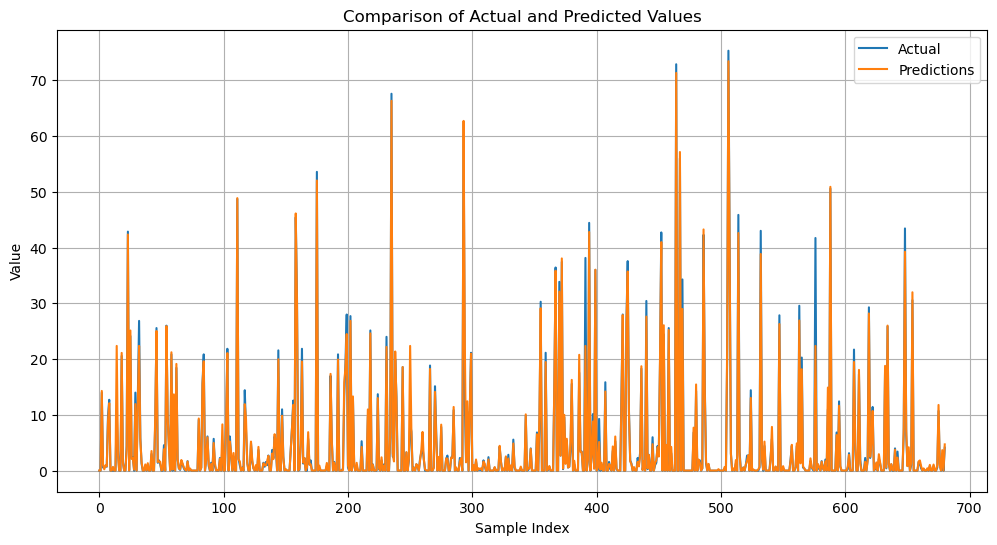

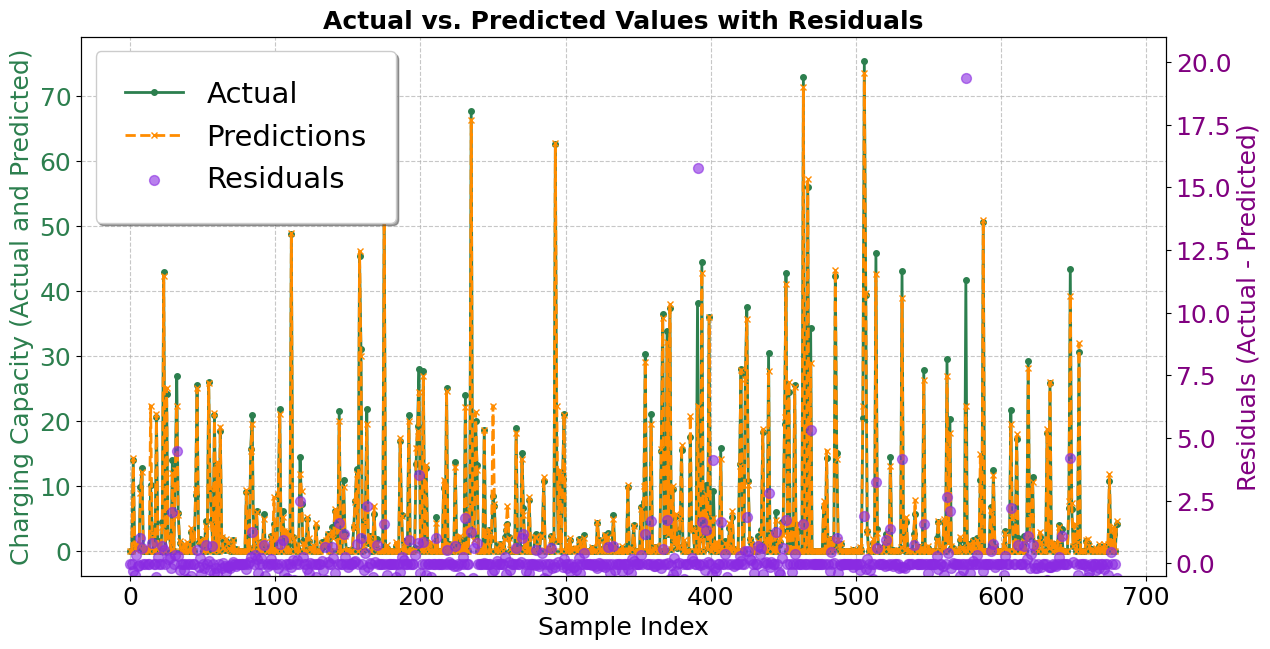

0.9440985


In [4]:
X_train, X_test, y_train, y_test = train_test_split(X_train_resampled, y_train_resampled, test_size = 0.3, random_state = 0)

xgb = XGBRegressor(n_estimators = 500, max_depth = 8, eta = 0.01, subsample = 0.7, colsample_bytree = 0.8)

# X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.2, random_state = 100)

xgb.fit(X_train_resampled, y_train_resampled)

y_xgb_train_pred = xgb.predict(X_train_resampled)
y_xgb_test_pred = xgb.predict(X_test)

# model performance
xgb_train_mse = mean_squared_error(y_train_resampled, y_xgb_train_pred)
xgb_train_r2 = r2_score(y_train_resampled, y_xgb_train_pred)

xgb_test_mse = mean_squared_error(y_test, y_xgb_test_pred)
xgb_test_r2 = r2_score(y_test, y_xgb_test_pred)

new_row = pd.DataFrame([['XGB', xgb_train_mse, xgb_train_r2, xgb_test_mse, xgb_test_r2 ]],
                       columns=['Method', 'Training MSE', 'Training R2', 'Test MSE', 'Test R2'])

print(new_row)

plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual')
plt.plot(y_xgb_test_pred, label='Predictions')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('Comparison of Actual and Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

# Calculate residuals
residuals = y_test - y_xgb_test_pred

# Create the figure and primary y-axis
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot actual vs. predicted values on the primary y-axis
ax1.plot(y_test, label='Actual', color='#2C7F4E', linestyle='-', linewidth=2, marker='o', markersize=4)
ax1.plot(y_xgb_test_pred, label='Predictions', color='#FF8C00', linestyle='--', linewidth=2, marker='x', markersize=4)
ax1.set_xlabel('Sample Index', fontsize=18)
ax1.set_ylabel('Charging Capacity (Actual and Predicted)', fontsize=18, color='#2C7F4E')
ax1.tick_params(axis='y', labelcolor='#2C7F4E', labelsize=18)
ax1.tick_params(axis='x', labelsize=18)  
ax1.set_title('Actual vs. Predicted Values with Residuals', fontsize=18, fontweight='bold')
ax1.grid(True, linestyle='--', alpha=0.7)

# Add the secondary y-axis for residuals
ax2 = ax1.twinx()
ax2.scatter(range(len(y_test)), residuals, color='#8A2BE2', alpha=0.6, marker='o', s=50, label='Residuals')
ax2.set_ylabel('Residuals (Actual - Predicted)', fontsize=18, color='purple')
ax2.tick_params(axis='y', labelcolor='purple', labelsize=18)
ax2.set_ylim(-0.5, None)

# Add legends for both y-axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2,  fontsize=21, frameon=True, fancybox=True, shadow=True, borderpad=1)

# Save and show plot
plt.savefig(r'Figures\trainingresults.pdf', bbox_inches='tight')
plt.show()

y_xgb_final_pred = xgb.predict(features_predict)
df_predict['EV_demand_pred'] = y_xgb_final_pred

def calculate_center_from_index(index):
    x_min, x_max, y_min, y_max = index
    center_x = (x_min + x_max) / 2
    center_y = (y_min + y_max) / 2
    return (center_x, center_y)

df_predict['center'] = df_predict.index.map(calculate_center_from_index)
print(df_predict['EV_demand_pred'].mean())
# df_predict_mean = df_predict[df_predict['EV_demand_pred'] > df_predict['EV_demand_pred'].mean()] ###########
df_predict_mean = df_predict

df_predict_final = df_predict_mean[['Hour', 'EV_demand_pred', 'center']].copy()
# df_predict_final['Coordinates'] = df_predict_mean.index
df_predict_final.reset_index(drop=True, inplace=True)


## Preparation for Stochastic Maximum Coverage Problem

In [5]:
df_GPrim_MinVolt = pd.read_csv('GridIntegration/BusVpu_min_12192024.csv', usecols=['Bus', 'Vpu_min'])

df_GPrim_coord = pd.read_csv('GridIntegration/allbuscoords.csv', usecols=['Location', 'Longitude', 'Latitude'])
filtered_PG_points_set = filter_df(df_GPrim_coord, min_lat_1, max_lat_1, min_long_1, max_long_1)
df_GPrim_coord['geometry_init'] = df_GPrim_coord.apply(
    lambda row: Point(row['Longitude'], row['Latitude']), axis=1
)
gdf_GPrim_coord = gpd.GeoDataFrame(df_GPrim_coord, geometry='geometry_init', crs="EPSG:4326")
gdf_GPrim_coord = gdf_GPrim_coord.to_crs(epsg=3857)
df_GPrim_coord['geometry'] = gdf_GPrim_coord['geometry_init']

merged_gdf_GPrim = pd.merge(gdf_GPrim_coord, df_GPrim_MinVolt, how="left", left_on="Location", right_on="Bus")
merged_gdf_GPrim.drop(columns=["Bus"], inplace=True)
merged_gdf_GPrim = merged_gdf_GPrim.dropna(subset=['Vpu_min'])
merged_gdf_GPrim = merged_gdf_GPrim.sort_values(by='Vpu_min', ascending=False)

grid_cells_ID, grid_cells, x_vals, y_vals = create_grid(minx, miny, maxx, maxy, grid_size)

i = 0
df_grid_volt = {}
for xi, x in enumerate(x_vals, start=1):
    for yi, y in enumerate(y_vals, start=1):
        grid_bounds = (x, x + grid_size, y, y + grid_size)
        
        x_min, x_max, y_min, y_max = grid_bounds

        number = 0
        grid_volt = []
        for _, row in merged_gdf_GPrim.iterrows():
            if x_min <= row["geometry_init"].x < x_max and y_min <= row["geometry_init"].y < y_max:
                number += 1
                grid_volt.append(row["Vpu_min"])
#                 if number >= 10:
                df_grid_volt[grid_bounds] = np.mean(grid_volt)
            if number >= 10: #######################################################################################
                break    

In [6]:
for key in df_grid_volt.keys():
    x_min, x_max, y_min, y_max = key
    
    for ind in df_predict_final.index:
        if x_min <= df_predict_final.loc[ind, "center"][0] < x_max and y_min <= df_predict_final.loc[ind, "center"][1] < y_max:
            df_predict_final.loc[ind, "avg_volt"] = df_grid_volt[key]   
            
    for ind in df_EV_filtered.index:
        if x_min <= df_EV_filtered.loc[ind, "Longitude_EPSG3857"] < x_max and y_min <= df_EV_filtered.loc[ind, "Latitude_EPSG3857"] < y_max:
            df_EV_filtered.loc[ind, "avg_volt"] = df_grid_volt[key]     

In [7]:
df_EV_filtered = df_EV_filtered.dropna(subset=['avg_volt'])
df_predict_final = df_predict_final.dropna(subset=['avg_volt'])

# Remove manually the extreme north candidate location for charger. 
center_to_remove = (-10882330.816974942, 3585573.7526442404)
df_predict_final = df_predict_final[df_predict_final['center'] != center_to_remove]


In [8]:
df_EV_predict_two_idx = df_predict_final.copy()
df_EV_predict_two_idx["PrimaryIndex"] = df_EV_predict_two_idx.index // 24
# df_EV_predict_two_idx = df_EV_predict_two_idx.set_index(["PrimaryIndex", "Hour"])

# df_EV_predict_two_idx = df_EV_predict_two_idx.reset_index()
df_EV_predict_two_idx["Hour"] = df_EV_predict_two_idx["Hour"].astype(int)
df_EV_predict_two_idx.set_index(['PrimaryIndex', 'Hour'], inplace=True)

df_EV_filtered = df_EV_filtered[['ChargerNumber', 'trainingHr', 'trainingEVdemand', 'Longitude_EPSG3857', 'Latitude_EPSG3857', 'avg_volt']]

In [9]:
df_EV_filtered['center'] = list(zip(df_EV_filtered['Longitude_EPSG3857'], df_EV_filtered['Latitude_EPSG3857']))
df_EV_filtered = df_EV_filtered[['ChargerNumber', 'center', 'trainingHr', 'trainingEVdemand', 'avg_volt']]
# df_predict_final["Mean Coverage (miles)"] = 2000
df_EV_filtered.index = range(1000, 1000 + len(df_EV_filtered))

In [10]:
existing_EV = []

for index, row in df_EV_filtered.iterrows():
    ev_demand_values = [float(value) for value in row["trainingEVdemand"].strip("[]").split(";")]
    
    for subindex, ev_demand in enumerate(ev_demand_values):
        existing_EV.append({
            "Index": index,
            "ChargerNumber": row["ChargerNumber"],
            "SubIndex": subindex,
            "trainingEVdemand": ev_demand,
            "center": row["center"],
            "avg_volt": row["avg_volt"]
        })

df_EV_existing_two_idx = pd.DataFrame(existing_EV)
df_EV_existing_two_idx.set_index(["Index", "SubIndex"], inplace=True)

In [11]:
pri_idx_df_EV_predict = df_EV_predict_two_idx.index.get_level_values(0).unique().to_numpy()
pri_idx_df_EV_existing = df_EV_existing_two_idx.index.get_level_values(0).unique().to_numpy()

In [12]:
average_EVdem_by_index = df_EV_existing_two_idx.groupby("Index")["trainingEVdemand"].mean()

In [13]:
c1 = {}
transformer = Transformer.from_crs("epsg:3857", "epsg:4326", always_xy=True)
for i in pri_idx_df_EV_predict:
    for j in pri_idx_df_EV_predict:
        point_i = transformer.transform(df_EV_predict_two_idx.loc[(i, 0), "center"][1], df_EV_predict_two_idx.loc[(i, 0), "center"][0])
        point_j = transformer.transform(df_EV_predict_two_idx.loc[(j, 0), "center"][1], df_EV_predict_two_idx.loc[(j, 0), "center"][0])
        c1[i, j] = haversine(point_i, point_j)
#         print(point_i, point_j)

In [14]:
c2 = {}
transformer = Transformer.from_crs("epsg:3857", "epsg:4326", always_xy=True)
for i in pri_idx_df_EV_predict:
    for j in pri_idx_df_EV_existing:
        point_i = transformer.transform(df_EV_predict_two_idx.loc[(i, 0), "center"][1], df_EV_predict_two_idx.loc[(i, 0), "center"][0])
        point_j = transformer.transform(df_EV_existing_two_idx.loc[(j, 0), "center"][1], df_EV_existing_two_idx.loc[(j, 0), "center"][0])
        c2[i, j] = haversine(point_i, point_j)

In [15]:
total_indices = list(set(pri_idx_df_EV_existing).union(set(pri_idx_df_EV_predict)))
c3 = {}

for idx in total_indices:
    if idx < 1000:
        c3[idx] = df_EV_predict_two_idx.loc[idx, 0]["avg_volt"]
    else:
        c3[idx] = df_EV_existing_two_idx.loc[idx, 0]["avg_volt"]

# Model and Solve: Stochastic Max Covering Problem

In [16]:
A1 = [(edge[0], edge[1]) for edge in c1.keys()] # Candidate to another candidate
A2 = [(edge[0], edge[1]) for edge in c2.keys()] # Candidate to another EV charger available
T = range(24)

# A3 = [(edge[0], edge[1]) for edge in c3.keys()] # 
# A4 = [ind for ind in c4.keys()]

### CASE 1:  Without opening a new charging station: Waiting Times

In [17]:
# i is the index of the customer to satisfy: traffic
# j is the index to open FACILITY: charger

# Capacity_EV = 3
# max_travel_dist = 500
# max_capacity_cand_charger = 25
# max_chargers = 25
# max_exist_chargers = 12

########################### parameters #########################

Capacity_EV = 3
max_travel_dist = 1000
max_capacity_cand_charger = 15
max_chargers = 250
max_exist_chargers = 50

################# model and variable definition ######################

mdl_1 = Model()
# Cand_dem = list(df_predict_final['EV_demand_pred']) # demand
Cand_len = pri_idx_df_EV_predict
EV_avail_len = pri_idx_df_EV_existing # all the available chargers

# total_indices = list(set(pri_idx_df_EV_existing).union(set(pri_idx_df_EV_predict)))

x1_1 = mdl_1.addVars(Cand_len, vtype = GRB.BINARY) # new charger stations (from candidate pts)
x2_1 = mdl_1.addVars(EV_avail_len, vtype = GRB.BINARY) # existing charger station, port added.

Capacity1_1 = mdl_1.addVars(Cand_len, vtype = GRB.INTEGER)
Capacity2_1 = mdl_1.addVars(EV_avail_len, vtype = GRB.INTEGER)

y1_1 = mdl_1.addVars(A1, T, vtype = GRB.CONTINUOUS)
y2_1 = mdl_1.addVars(A2, T, vtype = GRB.CONTINUOUS)

w1_1 = mdl_1.addVars(Cand_len, vtype = GRB.CONTINUOUS)
w2_1 = mdl_1.addVars(EV_avail_len, vtype = GRB.CONTINUOUS)

########################## objective function ##################################

mdl_1.modelSense = GRB.MINIMIZE 

mdl_1.setObjective(quicksum(50000 * x1_1[j] for j in Cand_len) + quicksum(1 * x2_1[j] for j in EV_avail_len)
                 + quicksum(50000 * Capacity1_1[j] for j in Cand_len) + quicksum(1 * Capacity2_1[j] for j in EV_avail_len)
                 + (1 / len(T)) * (quicksum(c1[i, j] * y1_1[i, j, t] for i, j in A1 for t in T) + quicksum(c2[i, j] * y2_1[i, j, t] for i, j in A2 for t in T))
                 - 1 * (quicksum(c3[j] * x1_1[j] for j in Cand_len) + quicksum(c3[j] * x2_1[j] for j in EV_avail_len))
                )

########################### constraints #################################

for t in T:
    for i in Cand_len:
        mdl_1.addConstr(quicksum(y1_1[i, j, t] for j in Cand_len if c1[i, j] < max_travel_dist) 
                        + quicksum(y2_1[i, j, t] for j in EV_avail_len if c2[i, j] < max_travel_dist) >= 
                        df_EV_predict_two_idx.loc[(i, t), "EV_demand_pred"])
        
for t in T:
    for j in Cand_len:
        mdl_1.addConstr(quicksum(y1_1[i, j, t] for i in Cand_len) <= w1_1[j])
    
for j in Cand_len:
    mdl_1.addConstr(w1_1[j] <= Capacity1_1[j])
    
for j in Cand_len:
    mdl_1.addConstr(w1_1[j] <= max_capacity_cand_charger * x1_1[j])
                
for j in Cand_len:
    mdl_1.addConstr(w1_1[j] >= Capacity1_1[j] - max_capacity_cand_charger * (1 - x1_1[j]))    
    
for j in Cand_len:
    mdl_1.addConstr(Capacity1_1[j] <= max_capacity_cand_charger)
    
for t in T:
    for j in EV_avail_len:
        mdl_1.addConstr(quicksum(y2_1[i, j, t] for i in Cand_len) <= w2_1[j])
    
for j in EV_avail_len:
    mdl_1.addConstr(w2_1[j] <= Capacity2_1[j])
    
for j in EV_avail_len:
    mdl_1.addConstr(w2_1[j] <= Capacity_EV * x2_1[j])
                
for j in EV_avail_len:
    mdl_1.addConstr(w2_1[j] >= Capacity2_1[j] - Capacity_EV * (1 - x2_1[j]))
    
for j in EV_avail_len:
    mdl_1.addConstr(Capacity2_1[j] <= Capacity_EV)

mdl_1.addConstr(quicksum(x1_1[j] for j in Cand_len) <= max_chargers)

mdl_1.addConstr(quicksum(x2_1[j] for j in EV_avail_len) <= max_exist_chargers)

mdl_1.Params.TimeLimit = 60 * 6
    
mdl_1.optimize()

Set parameter Username
Academic license - for non-commercial use only - expires 2026-01-15
Set parameter TimeLimit to value 360
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11.0 (22621.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-1365U, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 13510 rows, 621933 columns and 1255503 nonzeros
Model fingerprint: 0x9e933036
Variable types: 621071 continuous, 862 integer (431 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [6e-03, 5e+04]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-02, 3e+02]
Found heuristic solution: objective 1.385174e+07
Presolve removed 432 rows and 0 columns
Presolve time: 2.74s
Presolved: 13078 rows, 621933 columns, 1255012 nonzeros
Found heuristic solution: objective 1.385078e+07
Variable types: 620700 continuous, 1233 integer (431 binary)
Found heuristic solution: objecti

     0     0  403.55902    0  116  409.34939  403.55902  1.41%     -  151s
     0     0  403.56037    0  112  409.34939  403.56037  1.41%     -  152s
     0     0  403.56076    0  118  409.34939  403.56076  1.41%     -  152s
     0     0  403.56558    0  119  409.34939  403.56558  1.41%     -  159s
     0     0  403.56558    0  111  409.34939  403.56558  1.41%     -  160s
H    0     0                     408.5964861  403.56608  1.23%     -  161s
H    0     2                     408.5963639  403.56648  1.23%     -  178s
     0     2  403.56648    0  109  408.59636  403.56648  1.23%     -  178s
     1     4  403.56648    1  102  408.59636  403.56648  1.23%   129  181s
     3     8  403.57576    2  103  408.59636  403.56648  1.23%   595  190s
     7    16  403.59514    3   99  408.59636  403.57576  1.23%  1254  204s
    15    26  403.62955    4  102  408.59636  403.58581  1.23%  1233  218s
    25    36  403.64696    5   99  408.59636  403.58581  1.23%  1062  232s
H   35    46             

In [18]:
print("Objective function value:", mdl_1.objVal)

Objective function value: 406.2084732740679


In [19]:
active_assign_cand1_1 = {}
active_assign_cand2_1 = {}

for t in T:
    active_assign_cand1_1[t] = [(a[0], a[1]) for a in A1 if y1_1[a[0], a[1], t].x > 0]
    active_assign_cand2_1[t] = [(a[0], a[1]) for a in A2 if y2_1[a[0], a[1], t].x > 0]

actively_opened_stn1_1 = [i for i in Cand_len if x1_1[i].x > 0.5] 
actively_opened_stn2_1 = [i for i in EV_avail_len if x2_1[i].x > 0.5] 

Capacity_of_opened_stn1_1 = [Capacity1_1[i].x for i in Cand_len if x1_1[i].x > 0.5] 
Capacity_of_opened_stn2_1 = [Capacity2_1[i].x for i in EV_avail_len if x2_1[i].x > 0.5] 

In [20]:
Y_1 = {}
Y_max_1 = {}

for ind in pri_idx_df_EV_existing:
    for t in T:
        val = 0
        for item in A2:
            if item[1] == ind:
                val += y2_1[item[0], item[1], t].x * 120
        Y_1[t] = val # + average_EVdem_by_index[ind] * 15
    Y_max_1[ind] = np.mean(list(Y_1.values()))

In [21]:
df_actively_opened_stn1_1 = pd.DataFrame(actively_opened_stn1_1)
# df_actively_opened_stn1.columns = ['pri_idx_df_EV_predict']
# df_actively_opened_stn1.to_excel('newly_opened_chargers.xlsx', index = False)
len(actively_opened_stn1_1)

0

In [22]:
df_actively_opened_stn2_1 = pd.DataFrame(actively_opened_stn2_1)
# df_actively_opened_stn2.columns = ['pri_idx_df_EV_existing']
# df_actively_opened_stn2.to_excel('Expanded_existing_chargers.xlsx', index = False)
len(actively_opened_stn2_1)


50

### CASE 2: With opening new charging stations: Waiting Times

In [23]:
# i is the index of the customer to satisfy: traffic
# j is the index to open FACILITY: charger

########################### parameters #########################

Capacity_EV = 3
max_travel_dist = 1000
max_capacity_cand_charger = 15
max_chargers = 250
max_exist_chargers = 50

################# model and variable definition ######################

mdl_2 = Model()
# Cand_dem = list(df_predict_final['EV_demand_pred']) # demand
Cand_len = pri_idx_df_EV_predict
EV_avail_len = pri_idx_df_EV_existing # all the available chargers

total_indices = list(set(pri_idx_df_EV_existing).union(set(pri_idx_df_EV_predict)))

x1_2 = mdl_2.addVars(Cand_len, vtype = GRB.BINARY) # new charger stations (from candidate pts)
x2_2 = mdl_2.addVars(EV_avail_len, vtype = GRB.BINARY) # existing charger station, port added.

Capacity1_2 = mdl_2.addVars(Cand_len, vtype = GRB.INTEGER)
Capacity2_2 = mdl_2.addVars(EV_avail_len, vtype = GRB.INTEGER)

y1_2 = mdl_2.addVars(A1, T, vtype = GRB.CONTINUOUS)
y2_2 = mdl_2.addVars(A2, T, vtype = GRB.CONTINUOUS)

w1_2 = mdl_2.addVars(Cand_len, vtype = GRB.CONTINUOUS)
w2_2 = mdl_2.addVars(EV_avail_len, vtype = GRB.CONTINUOUS)

########################## objective function ##################################

mdl_2.modelSense = GRB.MINIMIZE 

# mdl_2.setObjective(quicksum(50000 * x1_2[j] for j in Cand_len) + quicksum(0 * x2_2[j] for j in EV_avail_len)
#                  + quicksum(3000 * Capacity1_2[j] for j in Cand_len) + quicksum(3000 * Capacity2_2[j] for j in EV_avail_len)
#                  + (1 / len(T)) * (quicksum(c1[i, j] * y1_2[i, j, t] for i, j in A1 for t in T) + quicksum(c2[i, j] * y2_2[i, j, t] for i, j in A2 for t in T))
#                  - 5 * (quicksum(c3[i] * x1_2[i] for i in Cand_len) + quicksum(c3[i] * x2_2[i] for i in EV_avail_len))
#                 )

mdl_2.setObjective(quicksum(50000 / 5000 * x1_2[j] for j in Cand_len) + quicksum(0 * x2_2[j] for j in EV_avail_len)
                 + quicksum(3000  / 10 * Capacity1_2[j] for j in Cand_len) + quicksum(3000  / 10 * Capacity2_2[j] for j in EV_avail_len)
                 + (1 / len(T)) * (quicksum(c1[i, j] * y1_2[i, j, t] for i, j in A1 for t in T) + quicksum(c2[i, j] * y2_2[i, j, t] for i, j in A2 for t in T))
                 - 5 * (quicksum(c3[j] * x1_2[j] for j in Cand_len) + quicksum(c3[j] * x2_2[j] for j in EV_avail_len))
                )
                 
########################### constraints #################################

for t in T:
    for i in Cand_len:
        mdl_2.addConstr(quicksum(y1_2[i, j, t] for j in Cand_len if c1[i, j] < max_travel_dist) 
                        + quicksum(y2_2[i, j, t] for j in EV_avail_len if c2[i, j] < max_travel_dist) >= 
                        df_EV_predict_two_idx.loc[(i, t), "EV_demand_pred"])      

for t in T:
    for j in Cand_len:
        mdl_2.addConstr(quicksum(y1_2[i, j, t] for i in Cand_len) <= w1_2[j])
    
for j in Cand_len:
    mdl_2.addConstr(w1_2[j] <= Capacity1_2[j])
    
for j in Cand_len:
    mdl_2.addConstr(w1_2[j] <= max_capacity_cand_charger * x1_2[j])
                
for j in Cand_len:
    mdl_2.addConstr(w1_2[j] >= Capacity1_2[j] - max_capacity_cand_charger * (1 - x1_2[j]))    
    
for j in Cand_len:
    mdl_2.addConstr(Capacity1_2[j] <= max_capacity_cand_charger)
    
for t in T:
    for j in EV_avail_len:
        mdl_2.addConstr(quicksum(y2_2[i, j, t] for i in Cand_len) <= w2_2[j])
    
for j in EV_avail_len:
    mdl_2.addConstr(w2_2[j] <= Capacity2_2[j])
    
for j in EV_avail_len:
    mdl_2.addConstr(w2_2[j] <= Capacity_EV * x2_2[j])
                
for j in EV_avail_len:
    mdl_2.addConstr(w2_2[j] >= Capacity2_2[j] - Capacity_EV * (1 - x2_2[j]))
    
for j in EV_avail_len:
    mdl_2.addConstr(Capacity2_2[j] <= Capacity_EV)    

mdl_2.addConstr(quicksum(x1_2[j] for j in Cand_len) <= max_chargers)

mdl_2.addConstr(quicksum(x2_2[j] for j in EV_avail_len) <= max_exist_chargers)

mdl_2.Params.TimeLimit = 60 * 6
    
mdl_2.optimize()

Set parameter TimeLimit to value 360
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11.0 (22621.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-1365U, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 13510 rows, 621933 columns and 1255503 nonzeros
Model fingerprint: 0xc20063aa
Variable types: 621071 continuous, 862 integer (431 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [5e-02, 3e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-02, 3e+02]
Found heuristic solution: objective 104915.00857
Presolve removed 432 rows and 0 columns
Presolve time: 2.72s
Presolved: 13078 rows, 621933 columns, 1255012 nonzeros
Found heuristic solution: objective 102758.27326
Variable types: 620700 continuous, 1233 integer (431 binary)
Found heuristic solution: objective 102158.27326
Deterministic concurrent LP optimizer: primal simplex, dual simplex, and ba


  Push phase complete: Pinf 0.0000000e+00, Dinf 5.1116774e-12     54s


Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
   55604    2.3043022e+04   0.000000e+00   0.000000e+00     54s
   55604    2.3043022e+04   0.000000e+00   0.000000e+00     54s

Root relaxation: objective 2.304302e+04, 55604 iterations, 50.53 seconds (15.77 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 23043.0223    0  157 102158.273 23043.0223  77.4%     -   54s
H    0     0                    33938.870935 23043.0223  32.1%     -   55s
H    0     0                    26965.402561 23043.0223  14.5%     -   57s
H    0     0                    23318.283607 23043.0223  1.18%     -   64s
     0     0 23062.3984    0  148 23318.2836 23062.3984  1.10%     -   67s
     0     0 23079.1276    0  153 23318.2836 23079.1276  1.03%     -   70s
     0     0 23091.

In [24]:
print("Objective function value:", mdl_2.objVal)

Objective function value: 23297.349413946904


In [25]:
active_assign_cand1_2 = {}
active_assign_cand2_2 = {}

for t in T:
    active_assign_cand1_2[t] = [(a[0], a[1]) for a in A1 if y1_2[a[0], a[1], t].x > 0]
    active_assign_cand2_2[t] = [(a[0], a[1]) for a in A2 if y2_2[a[0], a[1], t].x > 0]

actively_opened_stn1_2 = [i for i in Cand_len if x1_2[i].x > 0.5] 
actively_opened_stn2_2 = [i for i in EV_avail_len if x2_2[i].x > 0.5] 

Capacity_of_opened_stn1_2 = {}
Capacity_of_opened_stn2_2 = {}

Capacity_of_opened_stn1_2 = {i: Capacity1_2[i].x for i in Cand_len if x1_2[i].x > 0.5}
Capacity_of_opened_stn2_2 = {i: Capacity2_2[i].x for i in EV_avail_len if x2_2[i].x > 0.5}

In [26]:
Y_2 = {}
Y_max_2 = {} # average waiting time per charger (avg with respect to time). Also please note that this is only the avg WAITING TIME.

for ind in pri_idx_df_EV_existing:
    for t in T:
        val = 0
        for item in A2:
            if item[1] == ind:
                val += y2_2[item[0], item[1], t].x * 120
        Y_2[t] = val #+ average_EVdem_by_index[ind] * 15
    Y_max_2[ind] = np.mean(list(Y_2.values()))

In [27]:
df_actively_opened_stn1_2 = pd.DataFrame(actively_opened_stn1_2)
# df_actively_opened_stn1.columns = ['pri_idx_df_EV_predict']
# df_actively_opened_stn1.to_excel('newly_opened_chargers.xlsx', index = False)
len(actively_opened_stn1_2)

12

In [28]:
df_actively_opened_stn2_2 = pd.DataFrame(actively_opened_stn2_2)
# df_actively_opened_stn2.columns = ['pri_idx_df_EV_existing']
# df_actively_opened_stn2.to_excel('Expanded_existing_chargers.xlsx', index = False)
len(actively_opened_stn2_2)


50

## Comparison of Waiting Times: CASE 1 and CASE 2

In [29]:
values_1 = {}  # Dictionary for values_1
values_2 = {}  # Dictionary for values_2

for ind in pri_idx_df_EV_existing:  # Loop over primary indices
    if Y_max_1[ind] > 0:
        values_1[ind] = Y_max_1[ind]  # Add to values_1
        values_2[ind] = Y_max_2[ind] if Y_max_2[ind] > 0 else 0  # Add to values_2, or 0 if Y_max_2 is not > 0
    elif Y_max_2[ind] > 0:
        values_2[ind] = Y_max_2[ind]  # Add to values_2
        values_1[ind] = Y_max_1[ind] if Y_max_1[ind] > 0 else 0  # Add to values_1, or 0 if Y_max_1 is not > 0

# Calculate averages, considering only non-zero values
average_time_1 = sum(Y_max_1[ind] for ind in values_1 if values_1[ind] > 0) / len([v for v in values_1.values() if v > 0])
average_time_2 = sum(Y_max_2[ind] for ind in values_2 if values_2[ind] > 0) / len([v for v in values_2.values() if v > 0])


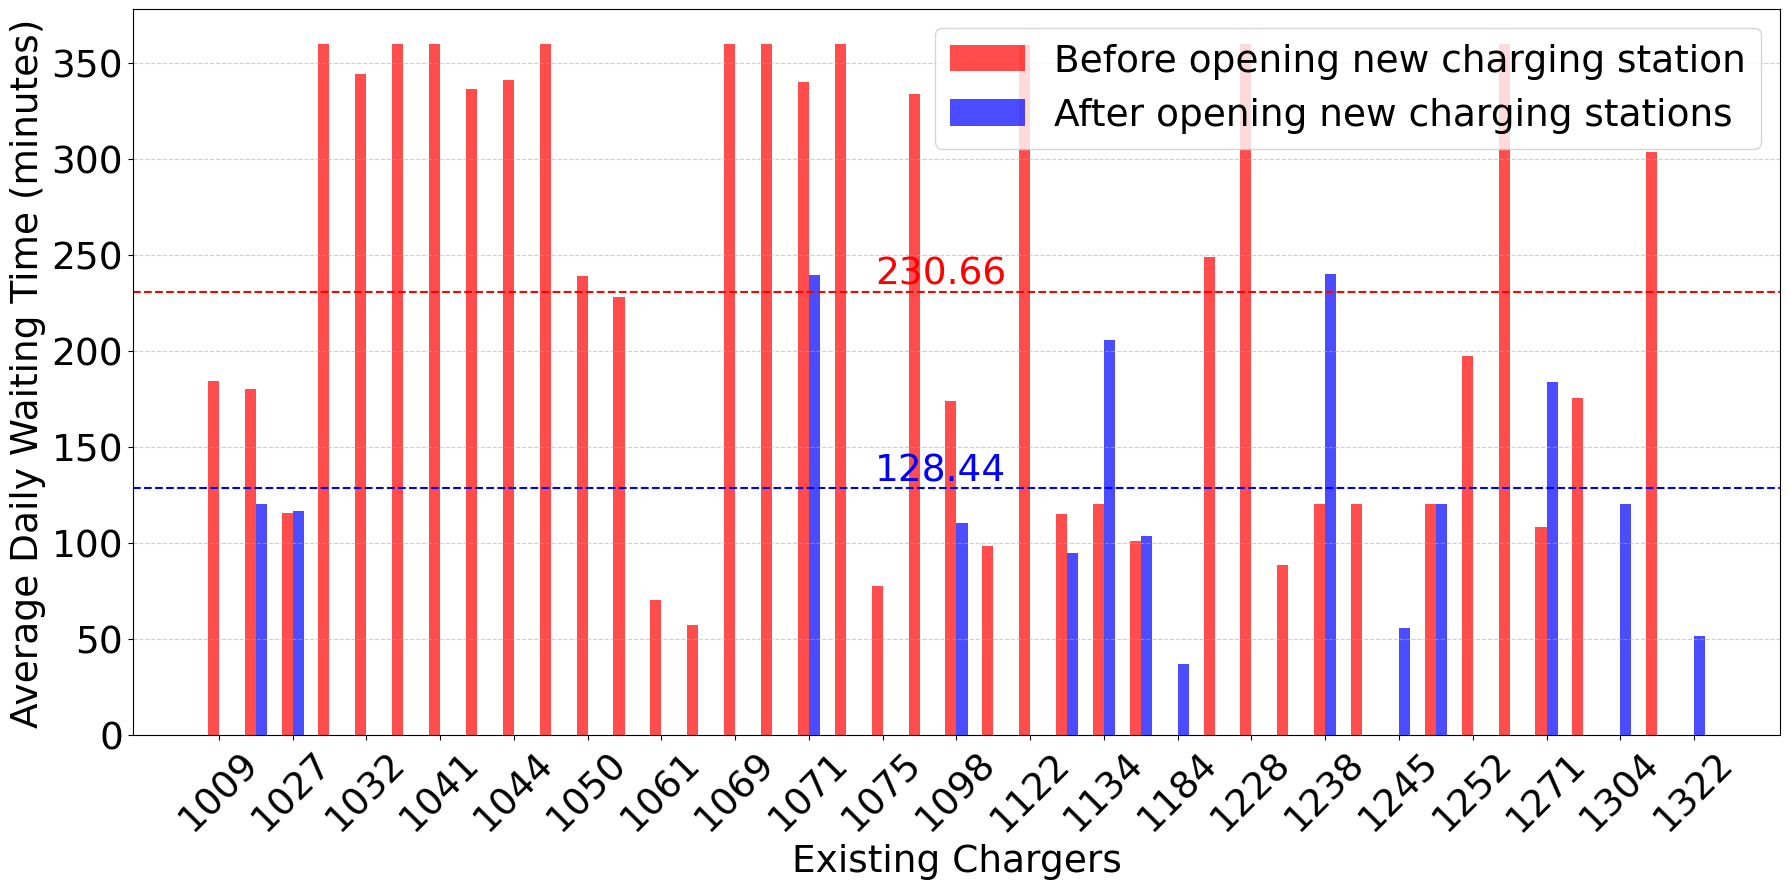

In [35]:
x = np.arange(len(values_1))  # positions for bars based on the number of keys

plt.figure(figsize=(18, 9))
width = 0.45
spacing = 1.5  # adjust this to control the extra space
x_spaced = np.arange(len(values_1)) * spacing 

# Extract keys and values from dictionaries
keys = list(values_1.keys())
values_1_list = list(values_1.values())
values_2_list = list(values_2.values())

# Plotting the bars
plt.bar(x_spaced - width / 2, values_1_list, width=width, label="Before opening new charging station", alpha=0.7, color="red")
plt.bar(x_spaced + width / 2, values_2_list, width=width, label="After opening new charging stations", alpha=0.7, color="blue")

# Add horizontal average lines
plt.axhline(y=average_time_1, color="red", linestyle="--")
plt.axhline(y=average_time_2, color="blue", linestyle="--")

# Annotate the averages on the plot
plt.text(x_spaced[-1] - 33.3, average_time_2, f"{average_time_2:.2f}", color="blue", ha="left", va="bottom", fontsize=27)
plt.text(x_spaced[-1] - 33.3, average_time_1, f"{average_time_1:.2f}", color="red", ha="left", va="bottom", fontsize=27)


# Set x-axis labels as keys from the dictionaries

plt.xticks(x_spaced[::2], keys[::2], rotation=45, fontsize=27)
plt.yticks(fontsize=27)  # Display dictionary keys as x-axis labels

# plt.tick_params(axis="x", which="both", length=0)  # Hide tick marks


# Labels and Title
plt.xlabel("Existing Chargers", fontsize=27)
plt.ylabel("Average Daily Waiting Time (minutes)", fontsize=27)
# plt.title("Average Waiting Time", fontsize=27)

# Add legend and grid
plt.legend(fontsize=27)
plt.grid(axis="y", linestyle="--", alpha=0.6)

# Show plot
plt.tight_layout()
plt.savefig('Figures/TravelTime_OR.pdf', bbox_inches='tight')
plt.show()



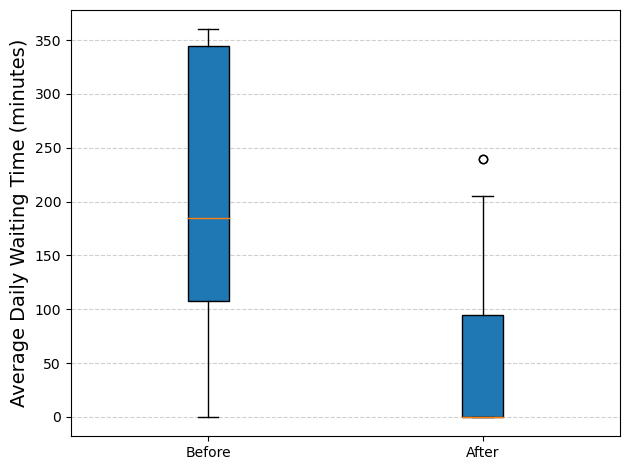

In [31]:
plt.boxplot([values_1_list, values_2_list], labels=["Before", "After"], patch_artist=True)

# Add titles and labels
# plt.title("Box Plots of Waiting Times", fontsize=16)
plt.ylabel("Average Daily Waiting Time (minutes)", fontsize=14)

# Show grid and plot
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

### Segregate the chargers (new and existing) and plot them 
### (plot the primary index of dataframe)

## Next, we will add the power grid coordinates

In [32]:
df_EV_predict_one_idx = df_EV_predict_two_idx.groupby("PrimaryIndex")["center"].first().reset_index()
df_EV_existing_one_idx = df_EV_existing_two_idx.groupby("Index")[["ChargerNumber", "center"]].first().reset_index()

# grouped_centers_exist = df_EV_existing_two_idx.groupby("Index")["center"].first() ############################## change this with above ###############################
# grouped_centers_predict = df_EV_predict_two_idx.groupby("PrimaryIndex")["center"].first() ############################## change this with above ###############################

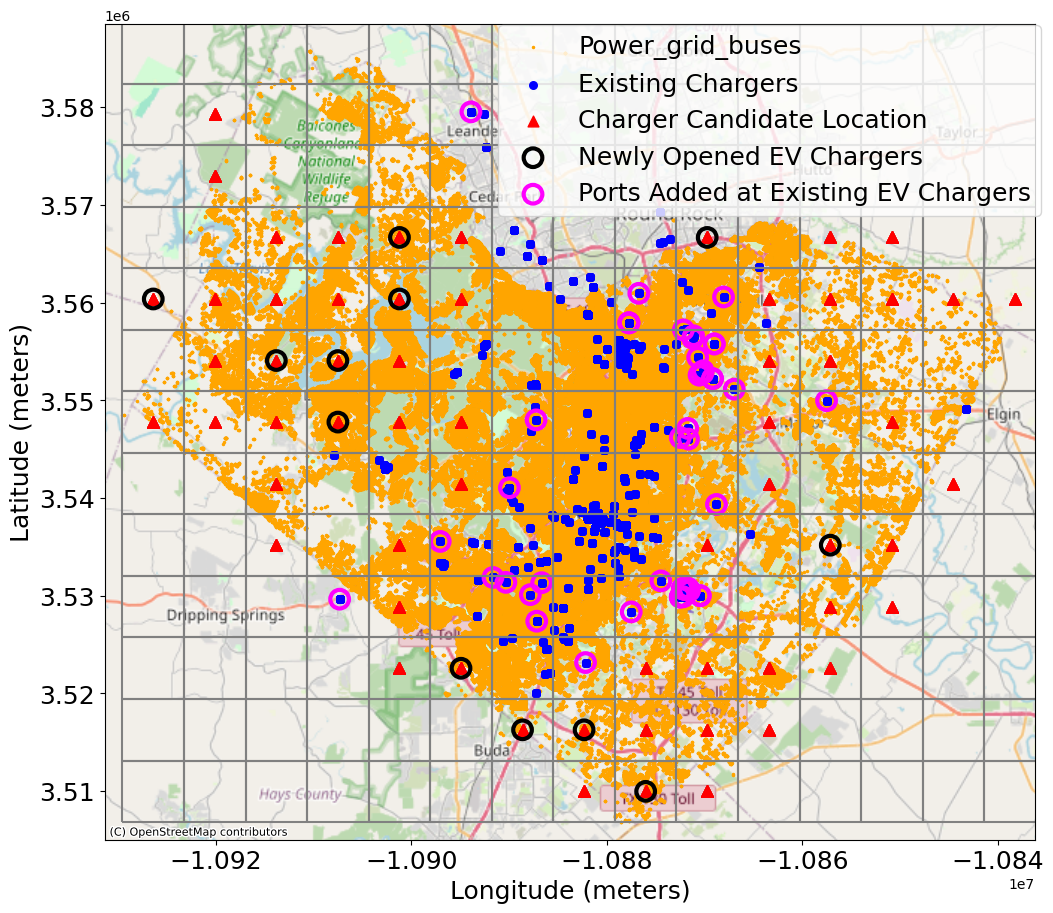

In [33]:
gdf_grid = gpd.GeoDataFrame(geometry=grid_cells, crs="EPSG:3857")

charger_geometries1 = [Point(df_EV_predict_two_idx.loc[(i, 0), "center"]) for i in actively_opened_stn1_2] # selected candidates for charger placement
charger_geometries2 = [Point(df_EV_existing_two_idx.loc[(i, 0), "center"]) for i in actively_opened_stn2_2] # selected candidates from the available chargers

final_charger1 = gpd.GeoDataFrame(geometry=charger_geometries1) # selected candidates for charger placement
final_charger2 = gpd.GeoDataFrame(geometry=charger_geometries2) # selected candidates from the available chargers

fig, ax = plt.subplots(figsize = (12, 12))

gdf_GPrim_coord['geometry_init'].plot(ax=ax, color='orange', label='Power_grid_buses',  marker='.', markersize=9)

x_vals0 = [coord[0] for coord in df_EV_existing_two_idx.loc[:, "center"]]
y_vals0 = [coord[1] for coord in df_EV_existing_two_idx.loc[:, "center"]]

gdf_grid.boundary.plot(ax = ax, color = "gray", linewidth = 1.5, alpha = 0.99)
ax.scatter(x_vals0, y_vals0, color='blue', marker='o', s = 30, label='Existing Chargers')

# for _, row in df_EV_predict_one_idx.iterrows():
#     x, y = row["center"]  # Unpack the center coordinates
#     ax.text(x, y, f'{row["PrimaryIndex"]}', fontsize=12, color='red')
    
x_vals1 = [coord[0] for coord in df_EV_predict_two_idx.loc[:, "center"]]
y_vals1 = [coord[1] for coord in df_EV_predict_two_idx.loc[:, "center"]]

ax.scatter(x_vals1, y_vals1, color='red', marker='^', s = 60, label='Charger Candidate Location')

# for _, row in df_EV_existing_one_idx.iterrows():
#     x, y = row["center"]  # Unpack the center coordinates
#     ax.text(x, y, f'{row["Index"]}', fontsize=12, color='blue')

x_coords1 = [point.x for point in final_charger1['geometry']]
y_coords1 = [point.y for point in final_charger1['geometry']]
ax.scatter(
    x_coords1, y_coords1, label='Newly Opened EV Chargers', 
    edgecolor='black', facecolor='none', s=180, linewidths=3, 
)

x_coords2 = [point.x for point in final_charger2['geometry']]
y_coords2 = [point.y for point in final_charger2['geometry']]
ax.scatter(
    x_coords2, y_coords2, label='Ports Added at Existing EV Chargers', 
    edgecolor='magenta', facecolor='none', s=180, linewidths=3)


x_vals2 = [coord[0] for coord in df_EV_predict_two_idx.loc[:, "center"]]
y_vals2 = [coord[1] for coord in df_EV_predict_two_idx.loc[:, "center"]]

ax.set_xlim([minx-1800, maxx+3600])
ax.set_ylim([miny-1800, maxy+2700])
ctx.add_basemap(ax, crs = gdf_set_1.crs.to_string(), source = ctx.providers.OpenStreetMap.Mapnik)
# ax.set_title("Solution from Maximum Coverage Problem", fontsize = 18)
plt.xlabel("Longitude (meters)",fontsize=18)
plt.ylabel("Latitude (meters)",fontsize = 18)
plt.legend(fontsize=18,  loc='lower right', bbox_to_anchor=(1.02, 0.75))
plt.xticks(fontsize=18)
plt.yticks(fontsize = 18)
plt.savefig('Figures/results_OR1.pdf', bbox_inches='tight')
plt.show()



In [34]:
df_chargers_newly_established = pd.DataFrame([{"charger": i, "x_coord": df_EV_predict_two_idx.loc[(i, 0), "center"][0], "y_coord": df_EV_predict_two_idx.loc[(i, 0), "center"][1],} for i in actively_opened_stn1_2])
df_chargers_newly_established["Ports"] = df_chargers_newly_established["charger"].map(Capacity_of_opened_stn1_2)
df_chargers_newly_established.to_csv("df_chargers_newly_established.csv", index=False)

df_chargers_existing_extended = pd.DataFrame([{"charger": i, "x_coord": df_EV_existing_two_idx.loc[(i, 0), "center"][0], "y_coord": df_EV_existing_two_idx.loc[(i, 0), "center"][1],} for i in actively_opened_stn2_2])
df_chargers_existing_extended["Extra ports added"] = df_chargers_existing_extended["charger"].map(Capacity_of_opened_stn2_2)
df_chargers_existing_extended.to_csv("df_chargers_existing_extended.csv", index=False)
